In [1]:
#!pip install pywaterflood

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import *
import scienceplots
from IPython.display import display_html

import proxy_crm_modules as pCRM
import pywaterflood.pywaterflood as pwf

<h3><b>1. Data Preprocessing</b></h3>
<p>Here, we process data for better understanding of the structure and plan out the things we need to do toward the data.</p>

In [58]:
prod = pd.read_excel("D:\crmProject\crmp_code_test\proxy_crm\data/rawdata.xlsx",sheet_name='producer',header=None,skiprows=1)

inj = pd.read_excel("D:\crmProject\crmp_code_test\proxy_crm\data/rawdata.xlsx",sheet_name='injector',header=None,skiprows=1)

time = pd.read_excel("D:\crmProject\crmp_code_test\proxy_crm\data/rawdata.xlsx",sheet_name='time',header=None)

bhp = pd.read_excel("D:\crmProject\crmp_code_test\proxy_crm\data/rawdata.xlsx",sheet_name='BHP',header=None,skiprows=1)

In [59]:
prod.head()

,0,1,2
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [60]:
prod.describe()

,0,1,2
count,949.000000,949.000000,949.000000
mean,3394.825571,102.488770,669.761704
std,2753.844083,355.143492,1408.923906
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,4205.115234,0.000000,0.000000
75%,5760.867676,71.397804,0.000000
max,9234.251953,3897.761963,5328.088379


In [61]:
inj.describe()

,0,1
count,949.000000,949.000000
mean,8074.245873,3495.875752
std,4682.233854,3028.572075
min,0.000000,0.000000
25%,6556.045898,0.000000
50%,9672.233398,3857.335938
75%,10519.791016,5605.107910
max,16101.299805,12087.867188


In [62]:
bhp.describe()

,0,1,2
count,949.000000,949.000000,949.000000
mean,118.297586,134.947781,27.972520
std,91.700550,139.772437,57.948639
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,156.331696,0.000000,0.000000
75%,176.908340,281.279022,0.000000
max,289.548157,293.477814,233.061050


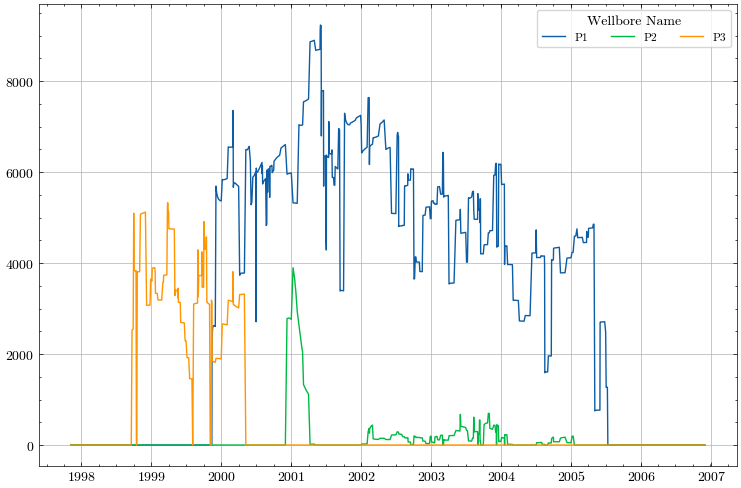

In [63]:
plt.subplots(figsize=(9,6))

plt.style.use(['science', 'no-latex'])

plt.plot(time.values, prod.values[:,0], label='P1')
plt.plot(time.values, prod.values[:,1], label='P2')
plt.plot(time.values, prod.values[:,2], label='P3')

plt.grid(True);plt.legend(title='Wellbore Name', ncol=3, fontsize='small', frameon=True)

plt.show()

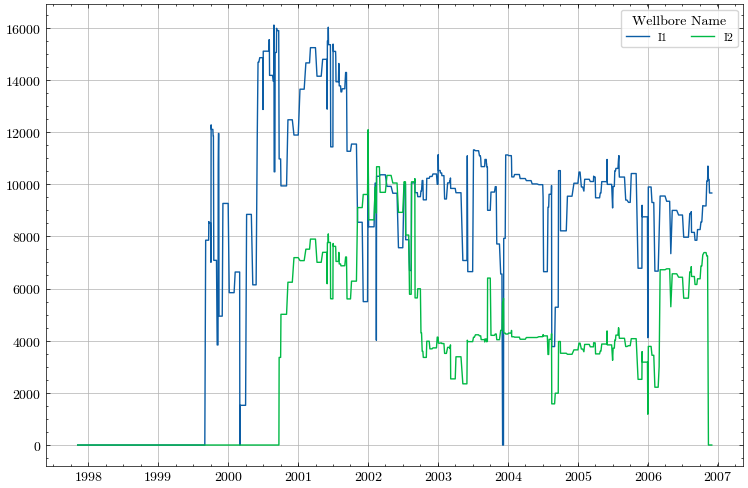

In [37]:
plt.subplots(figsize=(9,6))

plt.style.use(['science', 'no-latex'])

plt.plot(time.values, inj.values[:,0], label='I1')
plt.plot(time.values, inj.values[:,1], label='I2')

plt.grid(True);plt.legend(title='Wellbore Name', ncol=3, fontsize='small', frameon=True)

plt.show()

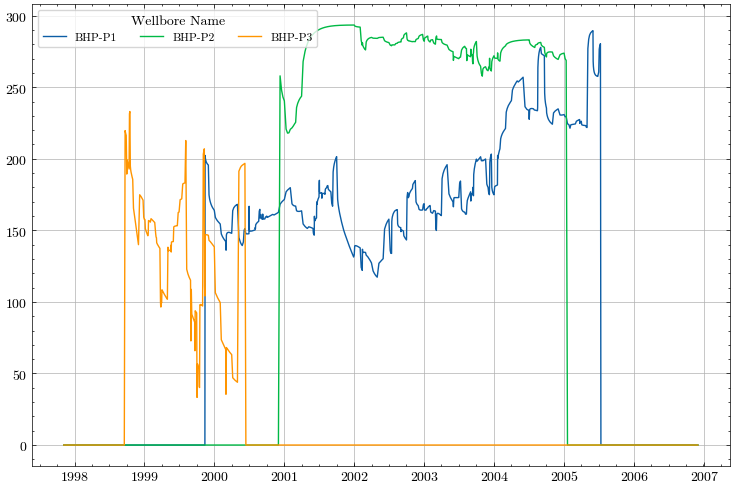

In [38]:
plt.subplots(figsize=(9,6))

plt.style.use(['science', 'no-latex'])

plt.plot(time.values, bhp.values[:,0], label='BHP-P1')
plt.plot(time.values, bhp.values[:,1], label='BHP-P2')
plt.plot(time.values, bhp.values[:,2], label='BHP-P3')

plt.grid(True);plt.legend(title='Wellbore Name', ncol=3, fontsize='small', frameon=True, loc='upper left')

plt.show()

In [ ]:
prod.drop(prod.index[0])

<h3><b>Apply CRM Model</b></h3>
<p>In this part, there are several cases that will be tackled using proxy-CRM model from proxyCRM_modules:<br><br>
1. <b>Case 1</b>: No shut-in well case.<br>
2. <b>Case 2</b>: One and multiple shut-in case.<br>
3. <b>Case 3</b>: One and multiple shut-in and well treatment case.</p><br>

In [10]:
train_size = int(0.875 * prod.shape[0])

In [11]:
inj_train = inj.values[:train_size]
prod_train = prod.values[:train_size]
time_train = time.values[:train_size].astype(float)
bhp_train = bhp.values[:train_size]

inj_test = inj.values[train_size:]
prod_test = prod.values[train_size:]
time_test = time.values[train_size:].astype(float)
press_test = bhp.values[train_size:]

In [12]:
proxy_crm = pCRM.proxyCRM()

In [15]:
proxy_crm.fit(prod_train, inj_train, bhp_train, time_train[:,0], num_cores=4)

In [17]:
q_hat_train = proxy_crm.predict()
q_hat_test = proxy_crm.predict(inj=inj_test, time=time_test[:,0].astype(float))

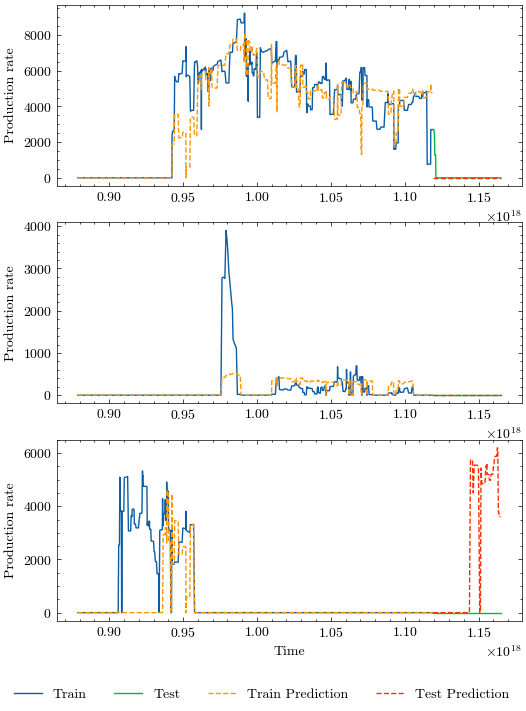

In [23]:
plt.style.use(['science', 'no-latex'])

fig, axes = plt.subplots(len(prod.columns), figsize=(6, 8))
for i, p in enumerate(prod):
    axes[i].plot(time_train, prod_train[:,i], label=f"Train")
    axes[i].plot(time_test, prod_test[:,i], label=f"Test")
    axes[i].plot(time_train, q_hat_train[:,i], ls="--", label=f"Train Prediction")
    axes[i].plot(time_test, q_hat_test[:,i], ls="--", label=f"Test Prediction")
    axes[i].set(ylabel="Production rate")
    axes[i].annotate(f"Producer{p}", xy=(7000, 100))
axes[i].set(xlabel="Time")
legend = axes[i].legend(bbox_to_anchor =(1, -0.3), ncol=4)

In [19]:
connectivity = pd.DataFrame(
    proxy_crm.lambda_ip,
    index=prod.columns.rename("Producer"),
    columns=inj.columns.rename("Injector"),
)
connectivity.T.style.highlight_max(color='yellow').format("{:.2}")

Producer,P1,P2,P3
Injector,,,
I1,0.38,0.028,0.37
I2,0.24,0.013,0.33


In [20]:
def rmse(test, pred):
  original_rmse = np.sqrt(((test-pred)**2/len(test)).sum())
  return original_rmse

result=[]
for j in range(prod.shape[1]):
  result.append(np.array(rmse(prod_test[:,j], q_hat_test[:,j])))

print(np.array(result))

[ 478.99502243    0.         3302.12353191]
